# Incremental learning part 2

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler

np.random.seed(1337) # for reproducibility


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


## Train and test on the immediate after section (scaling)

In [2]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings


def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    #Selection index due to using different window
    selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)[selection_index:]
    #moving_thres_crossings = generate_crossings_data(dir_path, time_range, window = thres_win, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    %reset -f in
    
    return all_data, time_label

In [3]:
#Load data and create the model
X, time_axis = generate_data("./data/Ramp22/", time_range = (-30,0), window = 2000, step = 10)  

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


In [18]:
def train(current_weights, X, time_axis, time_range, past_scaler):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    X_train = X[start_index:end_index]
    
    #Scaler stuffs
    scaler = past_scaler
    scaler.partial_fit(X_train)
    X_train = scaler.transform(X_train)
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=20, verbose = 0)
    
    new_weights = model.get_weights()
    
    return new_weights, scaler

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=12))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')

    return model

def prediction(new_weights, X, time_axis, time_range, scaler):
    
    print("Predicting for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    #Select data
    X_test = X[start_index:end_index]
    test_time = time_axis[start_index:end_index]
    
    #Create a model
    model = create_model()
    
    #Set the model to newly trained model
    model.set_weights(new_weights)
    
    X_test = scaler.transform(X_test)
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    #Plot the test loss
    plt.figure(figsize=(20,2))
    plt.plot(test_time, test_loss)
    plt.title("Reconstruction loss on {} with model trained on {}".format(time_range, (time_range[0] - 5, time_range[1] - 5)))
    plt.xlabel("Time [s]")
    plt.show()
    
    return np.median(test_loss)

def test_1(X, time_axis, time_range = (-30,0)):
    
    section_size = 5
    
    #For updating model
    current_weights = None
    new_weights = None
    
    #For keeping track of distribution history
    prev_dist = None
    dist = None
    
    #Create a model
    model = create_model()
    
    #Calculate number of sections
    num_section = int(abs(time_range[0])/section_size)
    print("Number of sections:", num_section)
    
    #Keeping tract of reconstruction for each model
    loss_tract = []
    
    #Initialize scaler
    past_scaler = MinMaxScaler()
    
    #Sequentially go through the data
    for i in range(num_section-1): #Don't train on last section (-5,0)
        
        time_range = (-section_size*(num_section - i), -section_size*(num_section - i - 1))
        #print("Entering sections: ", time_range)
       
        new_weights, scaler = train(current_weights, X, time_axis, time_range, past_scaler)
        
        #Keep track of current weights
        current_weights = new_weights
        
        #Do prediction on the next part
        #First have to select the next part
        test_time_range = (-section_size*(num_section - i - 1), -section_size*(num_section - i - 2))
        
        pred_loss = prediction(new_weights, X, time_axis, test_time_range, scaler)
              
        #Save the mean of test_loss
        loss_tract.append(pred_loss)
        
        #Set the new scaler to past scaler
        scaler = past_scaler
        
    #Bar plot
    print("Loss: ", loss_tract)
    labels = ['(-25,-20)', '(-20,-15)', '(-15,-10)', '(-10,-5)','(-5,0)']
    sections = np.arange(len(labels))
    plt.bar(sections, loss_tract)
    plt.xlabel("Time section")
    plt.ylabel("Average reconstruction loss")
    plt.xticks(sections, labels)

Number of sections: 6
Training for section:  (-30, -25)
Predicting for section:  (-25, -20)


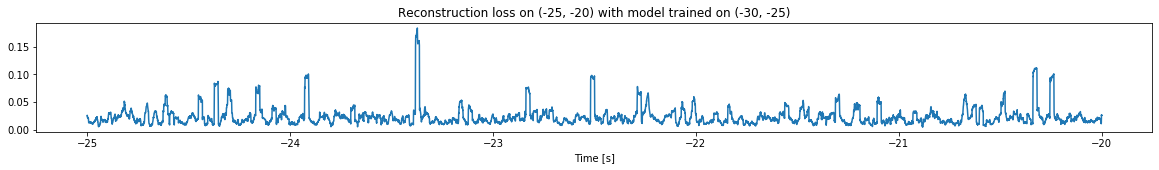

Training for section:  (-25, -20)
Predicting for section:  (-20, -15)


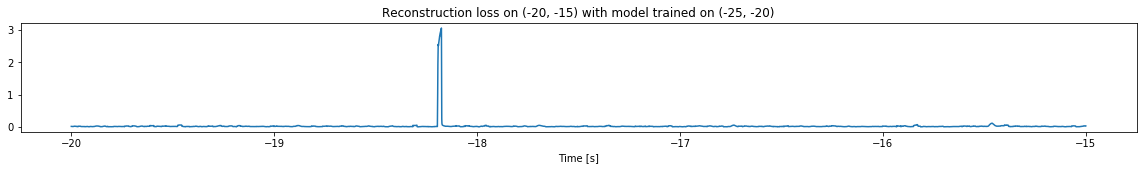

Training for section:  (-20, -15)
Predicting for section:  (-15, -10)


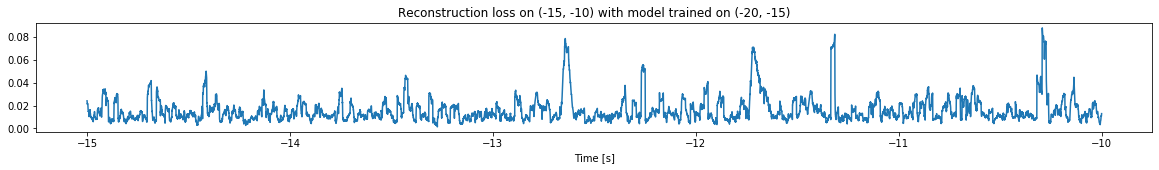

Training for section:  (-15, -10)
Predicting for section:  (-10, -5)


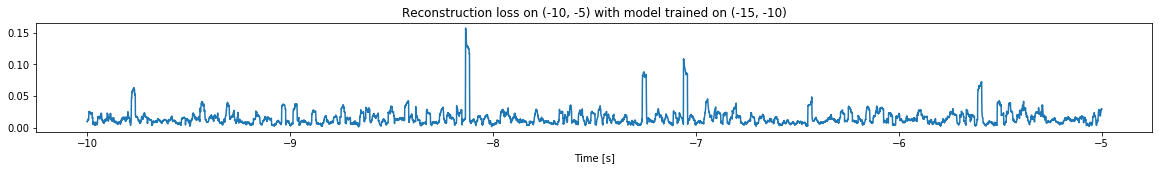

Training for section:  (-10, -5)
Predicting for section:  (-5, 0)


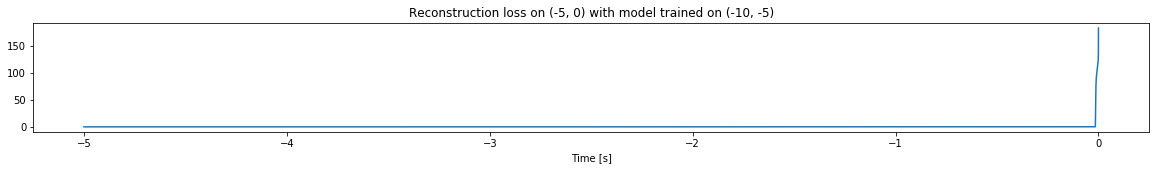

Loss:  [0.01995355683813479, 0.015188172317170113, 0.012908246520973343, 0.01235024568888465, 0.0138983446854328]


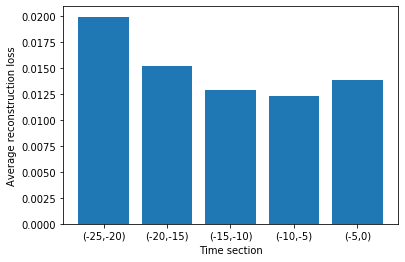

In [19]:
test_1(X, time_axis, time_range = (-30,0))